In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import re
from datetime import datetime

c = re.compile(r'.*?(2.*)\..*')

all_files = glob.glob("datasets/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(
            filename, 
            index_col=None, 
            parse_dates=['sale_time'], 
            date_format='%Y-%m-%d %H:%M:%S'
    )
    
    week = c.search(filename).group(1)
    df['week'] = datetime.strptime(week, '%Y-%m-%d')
    
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [9]:
df.head()

,sale_time,purchaser_gender,week
0,2012-10-01 01:42:22,female,2012-10-01
1,2012-10-01 02:24:53,female,2012-10-01
2,2012-10-01 02:25:40,female,2012-10-01
3,2012-10-01 02:30:42,female,2012-10-01
4,2012-10-01 02:51:32,male,2012-10-01


# Plot

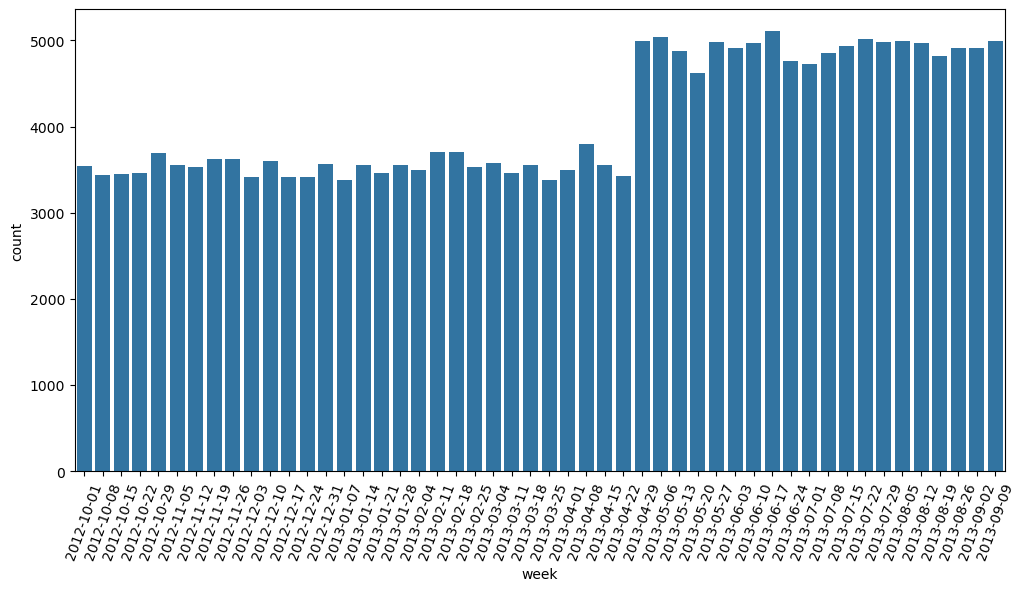

In [13]:
df_nbs = df.week.value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_nbs)
plt.xticks(rotation=70)
pass

# Data de mudança brusca em vendas

In [38]:
dt_mud, sales_mud = next(r for r in df_nbs.items() if r[1] > 4000)
dt_mud, sales_mud

(Timestamp('2013-04-29 00:00:00'), 4999)

# A mudança é estatísticamente significante?

\#TODO: melhorar

In [47]:
df_nbs_a = df_nbs.loc[:dt_mud].iloc[:-1]
df_nbs_a[:3]

week
2012-10-01    3545
2012-10-08    3440
2012-10-15    3451
Name: count, dtype: int64

assumindo que as vendas seguem uma distribuição normal, vamos estimar os parâmetros dessa distribuição e depois testar a probabilidade do valor da semana 2013-04-29 para essa distribuição

hipótese nula = o valor em 2013-04-29 foi gerado pela mesma distribuição que gerou os valores dos dias anteriores

In [48]:
from scipy.stats import norm
import numpy as np

mu, std = norm.fit(df_nbs_a)
mu, std

(np.float64(3530.8), np.float64(102.5532057031861))

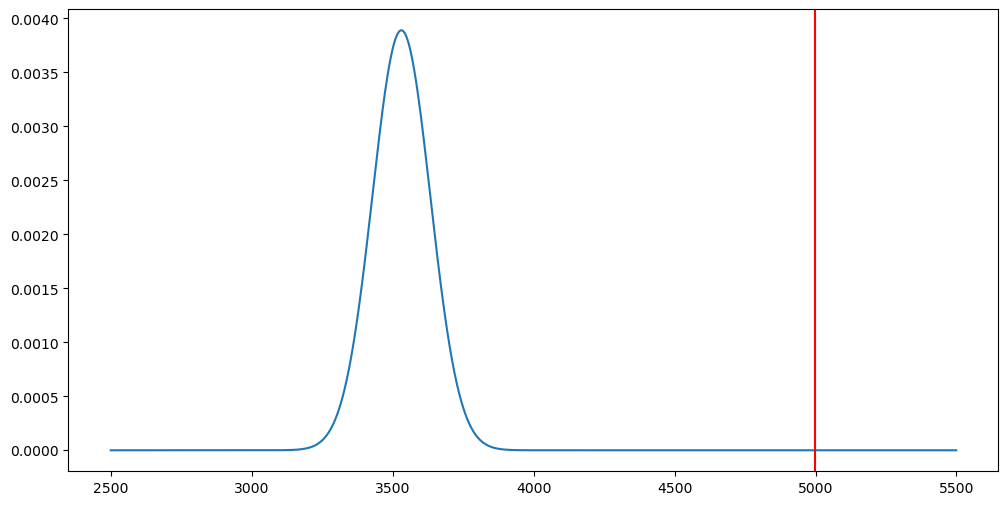

In [61]:
x_axis = np.arange(2500, 5500, 1)

plt.figure(figsize=(12, 6))
plt.plot(x_axis, norm.pdf(x_axis, mu, std))
plt.axvline(x=sales_mud, color='r')
plt.show()

In [52]:
p_sales_mud = norm.pdf(sales_mud, mu, std)
'p-value = {:.50%} ?'.format(p_sales_mud * 100)

'p-value = 0.00000000000000000000000000000000000000000012110739% ?'

# A mudança pode ter relação com proporção entre gêneros?

In [65]:
df_gbwg = pd.crosstab(df['week'], df['purchaser_gender'])

df_gbwg.head()

purchaser_gender,female,male
week,,
2012-10-01,2797,748
2012-10-08,2704,736
2012-10-15,2664,787
2012-10-22,2636,827
2012-10-29,2796,900


In [66]:
df_gbwg['pct_female'] = df_gbwg['female'] / (df_gbwg['female'] + df_gbwg['male'])

df_gbwg.head()

purchaser_gender,female,male,pct_female
week,,,
2012-10-01,2797,748,0.788999
2012-10-08,2704,736,0.786047
2012-10-15,2664,787,0.771950
2012-10-22,2636,827,0.761190
2012-10-29,2796,900,0.756494


In [82]:
pct_mud = df_gbwg.loc[dt_mud]['pct_female']
pct_mud

np.float64(0.4982996599319864)

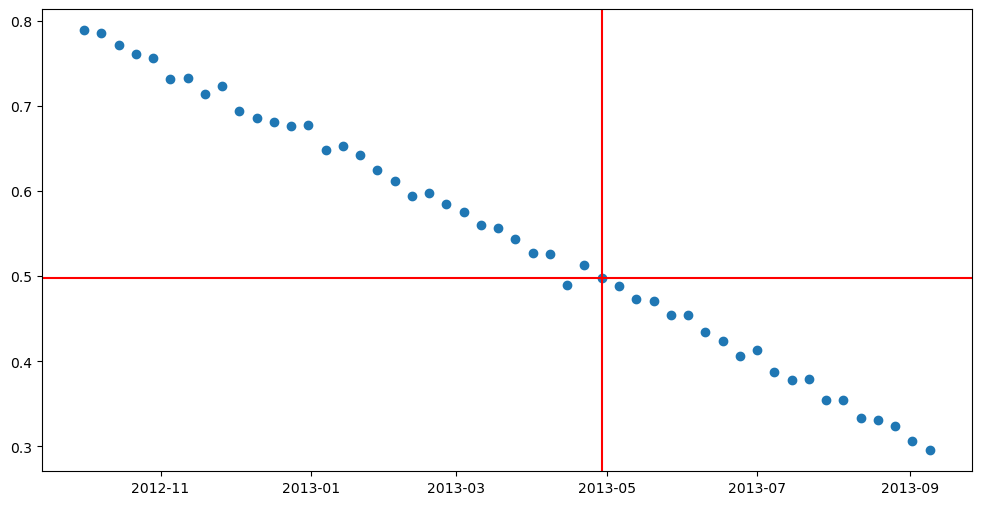

In [83]:
plt.figure(figsize=(12, 6))
plt.scatter(x=df_gbwg.index, y=df_gbwg['pct_female'])
plt.axvline(x=dt_mud, color='r')
plt.axhline(y=pct_mud, color='r')

Há uma queda gradual na participação feminina desde o início dos dados, não havendo alguma mudança que chame atenção na data em que houve o aumento brusco nas vendas. Curiosamente, foi o ponto em que o percentual chegou em torno de 50%

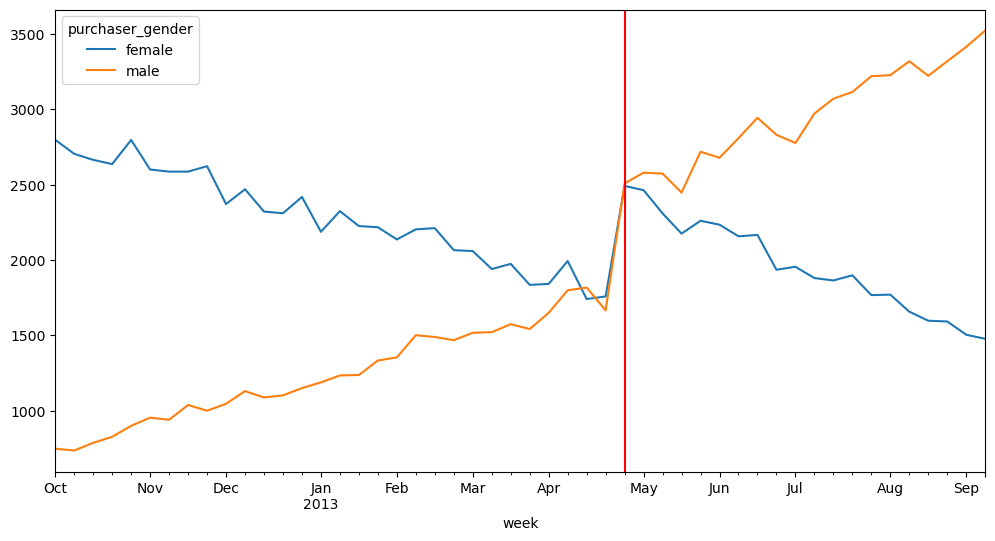

In [91]:
df_gbwg[['female', 'male']].plot(figsize=(12, 6))
plt.axvline(x=dt_mud, color='r')

Além disso, há um aumento nas vendas para ambos os sexos nesse dia, interrompendo uma tendência de queda nas vendas para mulheres, logo depois retomada

# Proporção de vendas por período do dia

In [96]:
from datetime import time

def map_time_daypart(x):
    if x >= time(0, 0, 0, 0) and x < time(6, 0, 0, 0):
        return 'night'
    elif x >= time(6, 0, 0, 0) and x < time(12, 0, 0, 0):
        return 'morning'
    elif x >= time(12, 0, 0, 0) and x < time(18, 0, 0, 0):
        return 'afternoon'
    else:
        return 'evening'
        
df['daypart'] = df.sale_time.dt.time.apply(map_time_daypart)

df.head()

,sale_time,purchaser_gender,week,daypart
0,2012-10-01 01:42:22,female,2012-10-01,night
1,2012-10-01 02:24:53,female,2012-10-01,night
2,2012-10-01 02:25:40,female,2012-10-01,night
3,2012-10-01 02:30:42,female,2012-10-01,night
4,2012-10-01 02:51:32,male,2012-10-01,night


In [105]:
df_gbwd = pd.crosstab(df['week'], df['daypart'], normalize='index')

df_gbwd.head()

daypart,afternoon,evening,morning,night
week,,,,
2012-10-01,0.393230,0.213258,0.302680,0.090832
2012-10-08,0.391860,0.207849,0.308721,0.091570
2012-10-15,0.395538,0.217908,0.299044,0.087511
2012-10-22,0.383771,0.223794,0.303783,0.088651
2012-10-29,0.401515,0.205357,0.305195,0.087933


<Axes: xlabel='week'>

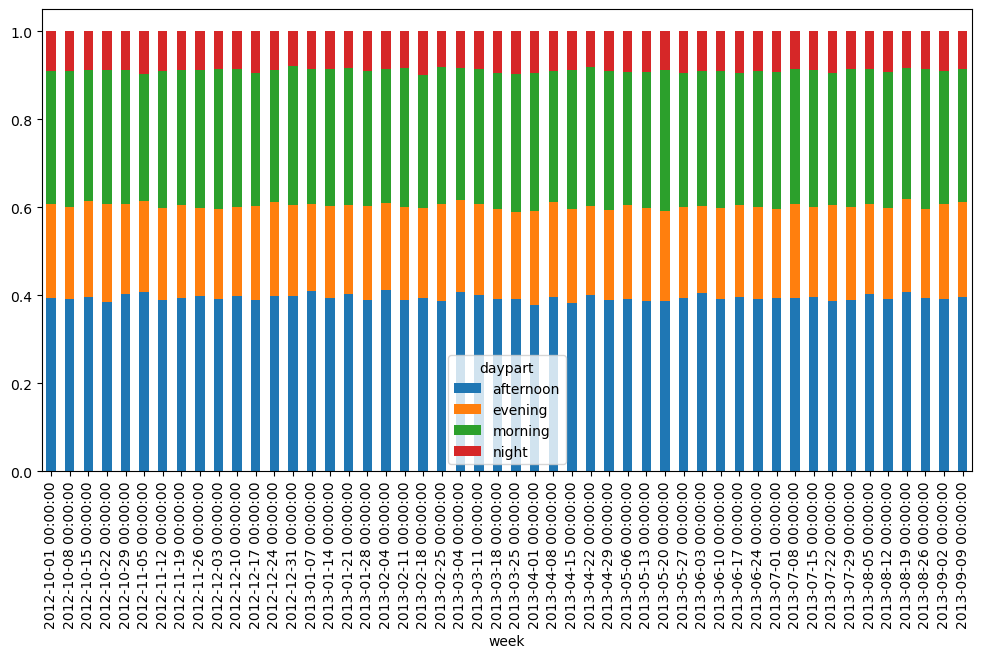

In [106]:
df_gbwd.plot(kind='bar', stacked=True, figsize=(12, 6))

In [110]:
df['daypart'].value_counts(normalize=True)

daypart
afternoon    0.394134
morning      0.307690
evening      0.208585
night        0.089591
Name: proportion, dtype: float64